In [17]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io as sio

from scipy.signal import welch

In [49]:
# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'  # Replace with your file path
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_raw = pd.read_excel(file_path, sheet_name=excel_sheet_name)

# Extract values from the first column into two arrays
healthy_sample = df_raw[df_raw.iloc[:, 1] == 99].iloc[:, 0].tolist()
depressed_sample = df_raw[df_raw.iloc[:, 1] != 99].iloc[:, 0].tolist()

# Print the results
print("Healthy sample:", healthy_sample)
print("Depressed sample:", depressed_sample)

Healthy sample: [507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 560, 562, 563, 564, 566, 568, 569, 570, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 588, 589, 590, 593, 596, 599, 600, 601, 603, 609, 611, 612, 615, 617, 619, 620, 621, 623]
Depressed sample: [558, 559, 561, 565, 567, 571, 572, 586, 587, 591, 592, 594, 595, 597, 598, 602, 604, 605, 606, 607, 608, 610, 613, 614, 616, 618, 622, 624, 625, 626, 627, 628]


In [ ]:
filename = 'eeg_source.mat'
eeg_source = h5py.File(filename, 'r')
eeg_source_open = eeg_source['eeg_source_open']
eeg_source_closed = eeg_source['eeg_source_closed']

def get_eeg_list(eeg_source, sample_list):
    eeg_keys = eeg_source.keys()
    return [eeg_source[f'x{sample}'] for sample in sample_list if f'x{sample}' in eeg_keys]

eeg_source_open_healthy = get_eeg_list(eeg_source_open, healthy_sample)
eeg_source_open_depressed = get_eeg_list(eeg_source_open, depressed_sample)
eeg_source_closed_healthy = get_eeg_list(eeg_source_closed, healthy_sample)
eeg_source_closed_depressed = get_eeg_list(eeg_source_closed, depressed_sample)

In [ ]:
def calculate_mean_psd(eeg_source):
    """
    Calculate the mean Power Spectral Density (PSD) for each subject's EEG data.
    Parameters:
        eeg_source: List of numpy arrays, each of shape (samples, channels, trials).
    Returns:
        mean_psd: Numpy array of shape (freqs, channels), mean PSD across subjects.
    """
    fs = 500
    nperseg = 512
    all_psds = []

    for i, subj_data in enumerate(eeg_source):
        if i % 10 == 0:
            print(f"Processing subject {i + 1} / {len(eeg_source)}")
        subj_data = np.array(subj_data)
        samples, n_channels, n_trials = subj_data.shape

        # Reshape to (samples, channels * trials)
        reshaped = subj_data.reshape(samples, n_channels * n_trials)
        freqs, psd = welch(reshaped, fs=fs, axis=0, nperseg=nperseg)
        # Reshape back to (freqs, channels, trials)
        psd = psd.reshape(freqs.shape[0], n_channels, n_trials)
        # Average across trials
        subj_psd_avg = np.mean(psd, axis=2)
        all_psds.append(subj_psd_avg)

    all_psds = np.stack(all_psds, axis=2)
    mean_psd = np.mean(all_psds, axis=2)
    print("\nMean PSD shape:", mean_psd.shape)
    return (mean_psd, freqs)


(psd_open_healthy, freqs) = calculate_mean_psd(eeg_source_open_healthy)
(psd_open_depressed, freqs) = calculate_mean_psd(eeg_source_open_depressed)
(psd_closed_healthy, freqs) = calculate_mean_psd(eeg_source_closed_healthy)
(psd_closed_depressed, freqs) = calculate_mean_psd(eeg_source_closed_depressed)

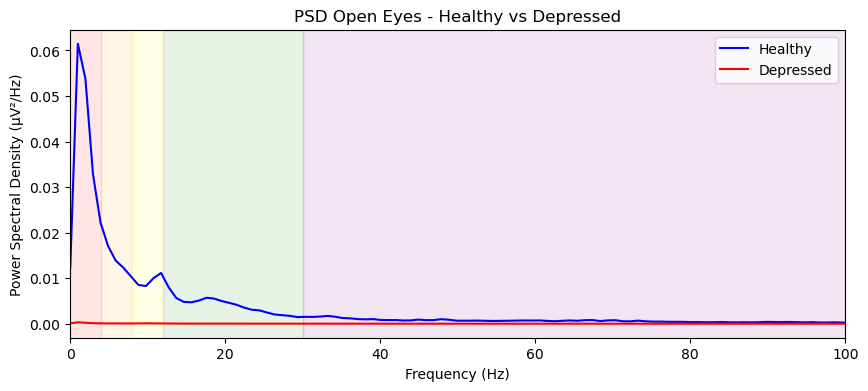

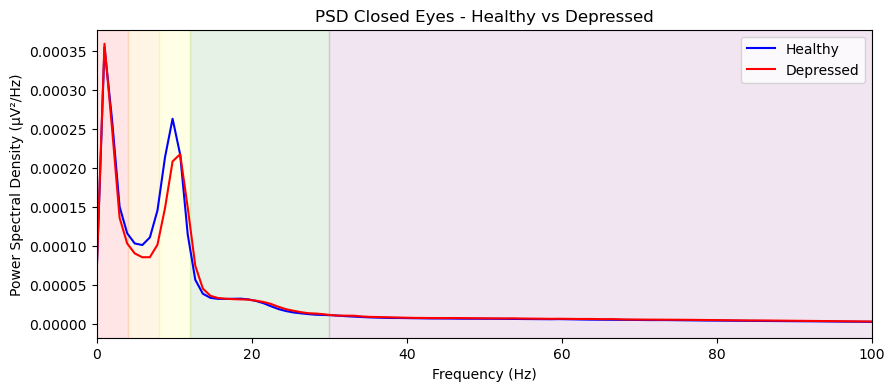

In [ ]:
def plot_psd(healthy_data, depressed_data, title):
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, healthy_data, label='Healthy', color='b')
    plt.plot(freqs, depressed_data, label='Depressed', color='r')
    plt.xlim(0, 100)
    # plt.ylim(0, 0.0004)

    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (µV²/Hz)')
    plt.legend()

    plt.axvspan(0, 4, color='red', alpha=0.1)  # delta
    plt.axvspan(4, 8, color='orange', alpha=0.1)  # theta
    plt.axvspan(8, 12, color='yellow', alpha=0.1)  # alpha
    plt.axvspan(12, 30, color='green', alpha=0.1)  # beta
    plt.axvspan(30, 100, color='purple', alpha=0.1)  # gamma
    
    plt.show()


# [sources x freqs] to [freqs]
mean_psd_open_healthy = np.mean(psd_open_healthy, axis=1)
mean_psd_open_depressed = np.mean(psd_open_depressed, axis=1)
mean_psd_closed_healthy = np.mean(psd_closed_healthy, axis=1)
mean_psd_closed_depressed = np.mean(psd_closed_depressed, axis=1)

plot_psd(mean_psd_open_healthy, mean_psd_open_depressed, 'PSD Open Eyes - Healthy vs Depressed')
plot_psd(mean_psd_closed_healthy, mean_psd_closed_depressed, 'PSD Closed Eyes - Healthy vs Depressed')

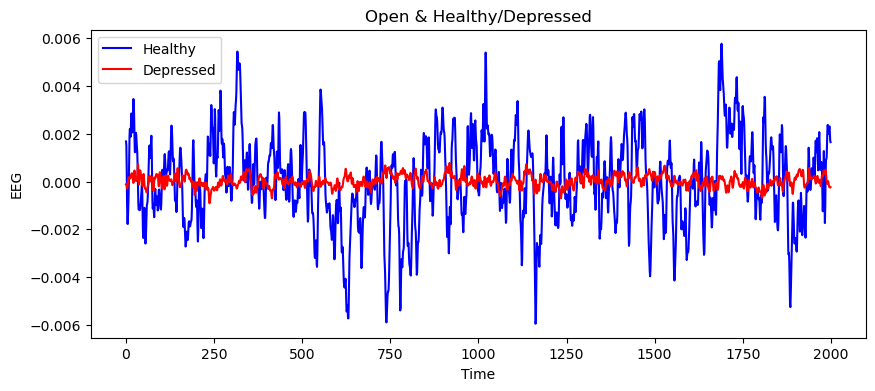

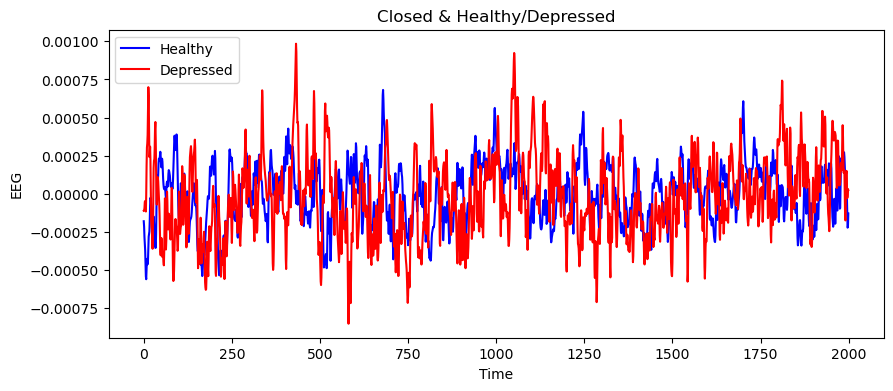

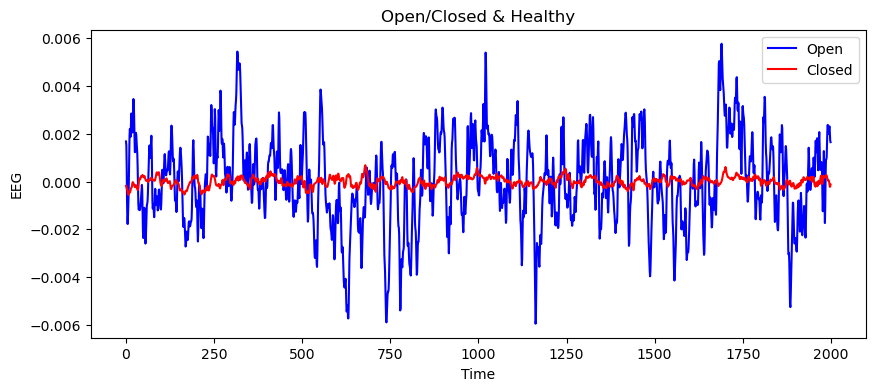

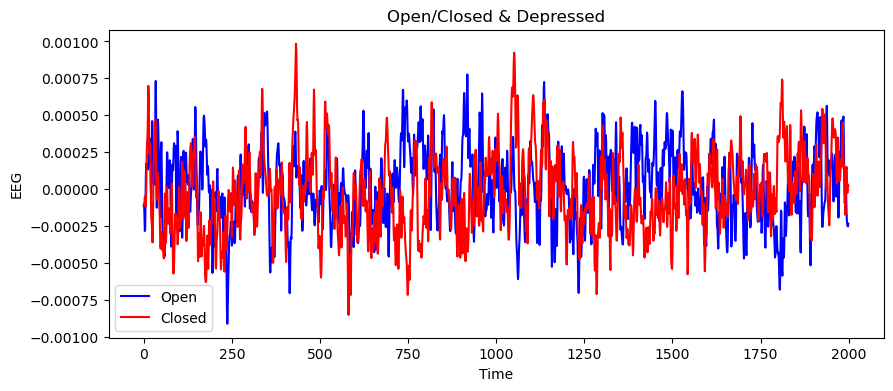

In [ ]:
def plot_avg_eeg(healthy_data, depressed_data, title, label_1='Healthy', label_2='Depressed'):
    healthy_signal = []
    for subject_data in healthy_data:
        subject_data = np.array(subject_data)
        subject_mean_signal = subject_data.mean(axis=(1, 2))
        healthy_signal.append(subject_mean_signal)

    depressed_signal = []
    for subject_data in depressed_data:
        subject_data = np.array(subject_data)
        subject_mean_signal = subject_data.mean(axis=(1, 2))
        depressed_signal.append(subject_mean_signal)

    healthy_mean_signal = np.mean(healthy_signal, axis=0)
    depressed_mean_signal = np.mean(depressed_signal, axis=0)

    plt.figure(figsize=(10, 4))
    plt.plot(healthy_mean_signal, label=label_1, color='b')
    plt.plot(depressed_mean_signal, label=label_2, color='r')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('EEG')
    plt.legend()
    plt.show()


plot_avg_eeg(eeg_source_open_healthy, eeg_source_open_depressed, 'Open & Healthy/Depressed')
plot_avg_eeg(eeg_source_closed_healthy, eeg_source_closed_depressed, 'Closed & Healthy/Depressed')
plot_avg_eeg(eeg_source_open_healthy, eeg_source_closed_healthy, 'Open/Closed & Healthy', 'Open', 'Closed')
plot_avg_eeg(eeg_source_open_depressed, eeg_source_closed_depressed, 'Open/Closed & Depressed', 'Open', 'Closed')